# Phase III: First ML Proof of Concept
## Solar Flares Peaks and Lengths

 - Baer Istok
 - Fiona Donohue
 - Harshini Moon
 - Evelyn Fabel

In [159]:
import requests
import pandas as pd
import numpy as np

api_key = 'f2asD6aVakycwYB4bQd6ANE3shr74umMDWTurH5x'
end_date = '2024-10-20'
start_date = '2024-09-20'


url = f'https://api.nasa.gov/DONKI/FLR?startDate={start_date}&endDate={end_date}&api_key={api_key}'

# Retrieves the data
response = requests.get(url)

# Stores the retreived data in a list
data = response.json()

In [178]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

df = pd.DataFrame(data)

# turns classType into one character
df['classType'] = df['classType'].apply(lambda x: x[:1])
df['classType'] = df['classType'].apply(lambda x: 1 if x == 'M' else 0)

# converts time strings into datetime objects
df['beginTime'] = df['beginTime'].apply(lambda x: datetime.fromisoformat(x))
df['peakTime'] = df['peakTime'].apply(lambda x: datetime.fromisoformat(x))
df['endTime'] = df['endTime'].apply(lambda x: datetime.fromisoformat(x))

# determines length of each solar flare in seconds
df['length'] = (df['endTime'] - df['beginTime']).dt.total_seconds()

# determines when the peak occurred 
df['peakPosition'] = (df['peakTime'] - df['beginTime']).dt.total_seconds() / df['length']

df = df.drop(columns=['instruments', 'sourceLocation', 'activeRegionNum',
                     'note', 'submissionTime', 'versionId', 'link', 'linkedEvents',
                     'flrID', 'catalog', 'beginTime', 'peakTime', 'endTime',], axis=1)
df

,classType,length,peakPosition
0,1,3180.0,0.509434
1,1,4260.0,0.464789
2,1,1560.0,0.576923
3,0,780.0,0.615385
4,1,1320.0,0.636364
...,...,...,...
83,1,780.0,0.615385
84,1,960.0,0.687500
85,1,1500.0,0.600000
86,1,900.0,0.533333


In [191]:
X = df.drop(['classType'], axis=1)
y = df['classType']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# transforms features with PolynomialFeatures
degree = 3
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# predictions
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# evaluations
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}")
print(f"Train R²: {train_r2:.3f}, Test R²: {test_r2:.3f}")

Train RMSE: 0.271, Test RMSE: 0.203
Train R²: 0.186, Test R²: 0.212


/Users/evelynfabel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/evelynfabel/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


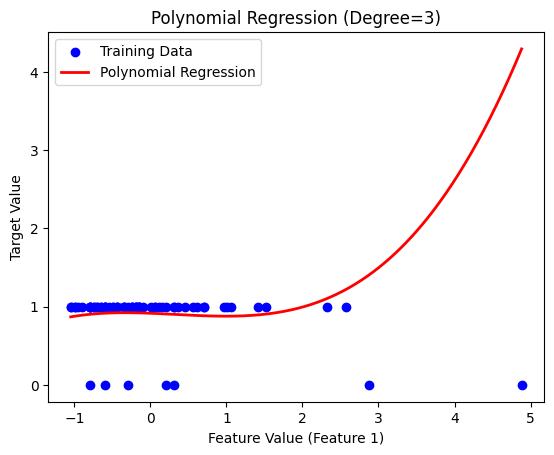

In [192]:
import matplotlib.pyplot as plt
import numpy as np

feature_index = 0  # Index of the feature you want to plot

X_plot = np.linspace(X_train_scaled[:, feature_index].min(), X_train_scaled[:, feature_index].max(), 500).reshape(-1, 1)

X_plot_full = np.tile(X_plot, (1, X_train_scaled.shape[1]))
X_plot_full[:, feature_index] = X_plot[:, 0]

X_plot_poly = poly.transform(X_plot_full)

# predicts target values
y_plot = model.predict(X_plot_poly)

# plots training data points (using first feature)
plt.scatter(X_train_scaled[:, feature_index], y_train, color='blue', label='Training Data')

# plots polynomial regression curve
plt.plot(X_plot, y_plot, color='red', linewidth=2, label='Polynomial Regression')

# labels/legend
plt.xlabel(f'Feature Value (Feature {feature_index + 1})')
plt.ylabel('Target Value')
plt.title(f'Polynomial Regression (Degree={degree})')
plt.legend()
plt.show()
